# Demand Forecasting & Scenario Modeling

This notebook builds weekly demand forecasts for a travel platform using historical booking data.
The objective is to generate interpretable, seasonality-aware forecasts that can be translated
into revenue, capacity utilization, and financial planning insights.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv(
    "cleaned_hotel_bookings.csv",
    parse_dates=["arrival_date", "week_start"]
)

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stay_nights,arrival_date,week_start,gross_booking,net_booking,revenue
0,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,Check-Out,02-07-2015,1,2015-07-01,2015-06-29,1,1,75.0
1,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,Check-Out,02-07-2015,1,2015-07-01,2015-06-29,1,1,75.0
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,1,Check-Out,03-07-2015,2,2015-07-01,2015-06-29,1,1,196.0
3,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,1,Check-Out,03-07-2015,2,2015-07-01,2015-06-29,1,1,196.0
4,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,0,0,Check-Out,03-07-2015,2,2015-07-01,2015-06-29,1,1,214.0


In [3]:
weekly = (
    df.groupby(["week_start", "hotel"])
      .agg(
          net_bookings=("net_booking", "sum"),
          room_nights=("total_stay_nights", "sum"),
          avg_adr=("adr", "mean")
      )
      .reset_index()
)

weekly.head()

,week_start,hotel,net_bookings,room_nights,avg_adr
0,2015-06-29,City Hotel,85,525,77.674158
1,2015-06-29,Resort Hotel,171,1216,102.208091
2,2015-07-06,City Hotel,61,710,71.252366
3,2015-07-06,Resort Hotel,218,1448,115.213872
4,2015-07-13,City Hotel,123,952,73.904353


In [4]:
weekly_pivot = (
    weekly.pivot(index="week_start", columns="hotel", values="room_nights")
          .sort_index()
)

weekly_pivot.head()

hotel,City Hotel,Resort Hotel
week_start,,
2015-06-29,525,1216
2015-07-06,710,1448
2015-07-13,952,1599
2015-07-20,1110,1680
2015-07-27,587,1864


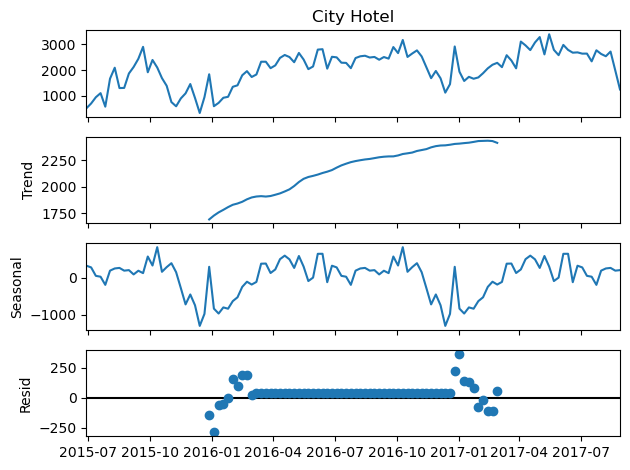

In [5]:
# Seasonality Validation 
# City Hotel Decomposition
city_series = weekly_pivot["City Hotel"].dropna()

decomp_city = seasonal_decompose(city_series, model="additive", period=52)

decomp_city.plot()
plt.show()

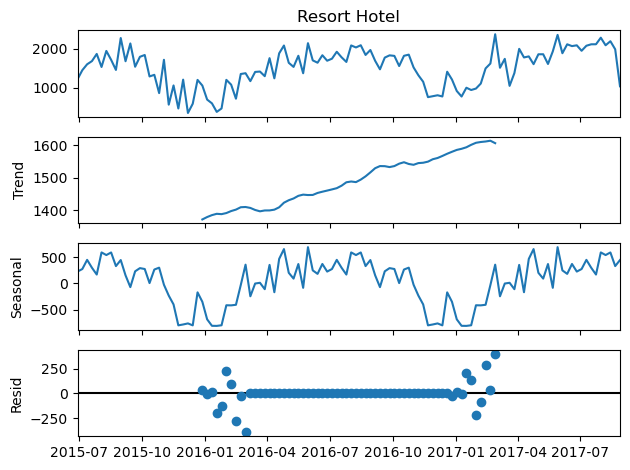

In [6]:
# Resort Hotel Decomposition
resort_series = weekly_pivot["Resort Hotel"].dropna()

decomp_resort = seasonal_decompose(resort_series, model="additive", period=52)

decomp_resort.plot()
plt.show()

Seasonal decomposition confirms strong annual seasonality (52-week cycle) in both City and Resort demand,
with higher amplitude observed in Resort hotels. This validates the use of seasonal forecasting models.

In [7]:
# Train–Test Split (Time-Series Correct)
train_end = int(len(city_series) * 0.85)

city_train, city_test = city_series[:train_end], city_series[train_end:]
resort_train, resort_test = resort_series[:train_end], resort_series[train_end:]

In [8]:
len(city_series), len(resort_series)

(114, 114)

In [9]:
weekly_pivot = weekly_pivot.sort_index()
weekly_pivot = weekly_pivot.asfreq("W-MON")

In [10]:
weekly_pivot.isna().sum()

hotel
City Hotel      0
Resort Hotel    0
dtype: int64

In [11]:
city_series = weekly_pivot["City Hotel"]
resort_series = weekly_pivot["Resort Hotel"]


In [12]:
# Model 1: Exponential Smoothing (ETS)
# City Hotel

ets_city = ExponentialSmoothing(
    city_series,
    trend="add",
    damped_trend=True,
    seasonal=None
).fit(optimized=True)

city_ets_forecast = ets_city.forecast(len(city_test))

In [13]:
# Resort Hotel
ets_resort = ExponentialSmoothing(
    resort_series,
    trend="add",
    seasonal="add",
    seasonal_periods=52
).fit(optimized=True)

resort_ets_forecast = ets_resort.forecast(len(resort_test))

In [14]:
# Model 2: SARIMA (Seasonal ARIMA)
# City Hotel
sarima_city = SARIMAX(
    city_series,
    order=(1,1,0),
    seasonal_order=(1,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

city_sarima_forecast = sarima_city.forecast(len(city_test))

In [15]:
# Resort Hotel
sarima_resort = SARIMAX(
    resort_series,
    order=(1,1,0),
    seasonal_order=(1,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

resort_sarima_forecast = sarima_resort.forecast(len(resort_test))

In [16]:
# Rolling Validation (Finance-credible accuracy)
def mape(actual, forecast):
    return mean_absolute_percentage_error(actual, forecast) * 100


results = pd.DataFrame({
    "Model": ["ETS City", "SARIMA City", "ETS Resort", "SARIMA Resort"],
    "MAPE (%)": [
        mape(city_test, city_ets_forecast),
        mape(city_test, city_sarima_forecast),
        mape(resort_test, resort_ets_forecast),
        mape(resort_test, resort_sarima_forecast),
    ]
})

results


,Model,MAPE (%)
0,ETS City,48.431432
1,SARIMA City,45.833175
2,ETS Resort,30.797337
3,SARIMA Resort,40.151125


In [17]:
# Final forecast
forecast_horizon = 52

final_city_model = ets_city if results.loc[0,"MAPE (%)"] < results.loc[1,"MAPE (%)"] else sarima_city
final_resort_model = ets_resort if results.loc[2,"MAPE (%)"] < results.loc[3,"MAPE (%)"] else sarima_resort

city_forecast = final_city_model.forecast(forecast_horizon)
resort_forecast = final_resort_model.forecast(forecast_horizon)

In [18]:
# Scenario Generation (Finance Layer Input)
scenario_df = pd.DataFrame({
    "Week": city_forecast.index,
    "City_Base": city_forecast,
    "City_Peak": city_forecast * 1.15,
    "City_Shock": city_forecast * 0.90,
    "Resort_Base": resort_forecast,
    "Resort_Peak": resort_forecast * 1.15,
    "Resort_Shock": resort_forecast * 0.90
})

scenario_df.head()

,Week,City_Base,City_Peak,City_Shock,Resort_Base,Resort_Peak,Resort_Shock
2017-09-04,2017-09-04,1461.475063,1680.696323,1315.327557,1773.776184,2039.842612,1596.398566
2017-09-11,2017-09-11,1415.663722,1628.013280,1274.097350,1721.900467,1980.185537,1549.710421
2017-09-18,2017-09-18,1421.760494,1635.024569,1279.584445,1782.939894,2050.380878,1604.645905
2017-09-25,2017-09-25,1557.574743,1791.210954,1401.817269,1889.917300,2173.404895,1700.925570
2017-10-02,2017-10-02,1484.972027,1707.717832,1336.474825,1885.917514,2168.805141,1697.325763


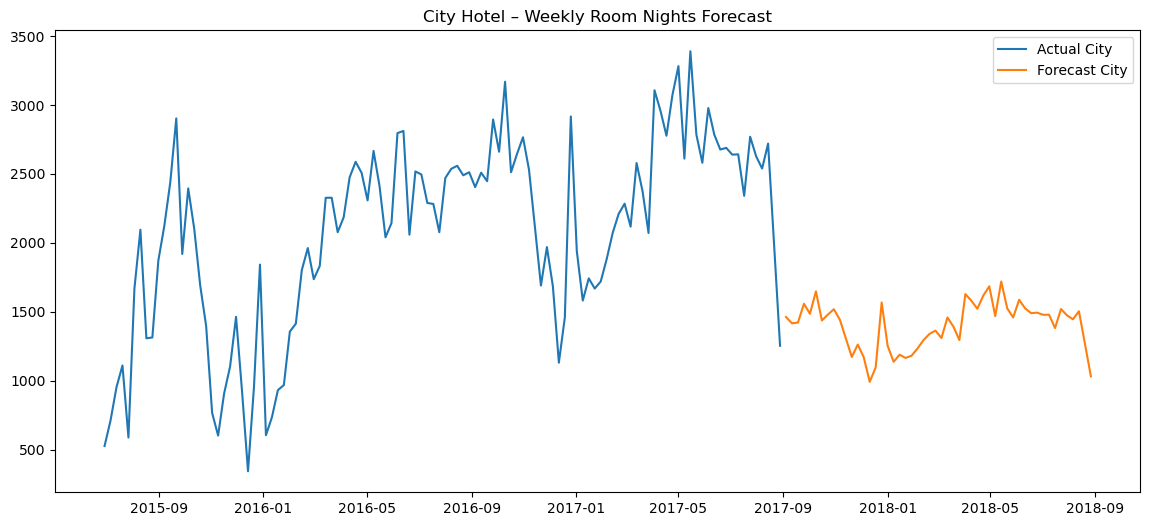

In [19]:
# Final Forecasts
# City Hotel
plt.figure(figsize=(14,6))
plt.plot(city_series, label="Actual City")
plt.plot(city_forecast, label="Forecast City")
plt.title("City Hotel – Weekly Room Nights Forecast")
plt.legend()
plt.show()

The initial city Hotel forecast shows a pronounced downward level shift immediately after the forecast origin, with projected demand stabilizing significantly below recent historical levels. This behavior indicates that the model is over-weighting long-term historical averages and seasonal structure relative to the most recent demand regime.

City demand exhibits multiple structural changes and sharp disruptions, suggesting that it is driven more by trend and external shocks than by stable seasonal patterns. Applying a fully seasonal ETS model in this context causes the forecast to revert toward a long-run mean rather than anchoring to the latest observed demand. This highlights the risk of imposing strong seasonality assumptions on series with heterogeneous demand drivers.

As a result, the initial model understates near-term City demand and would lead to overly conservative revenue and capacity planning decisions if used without adjustment.

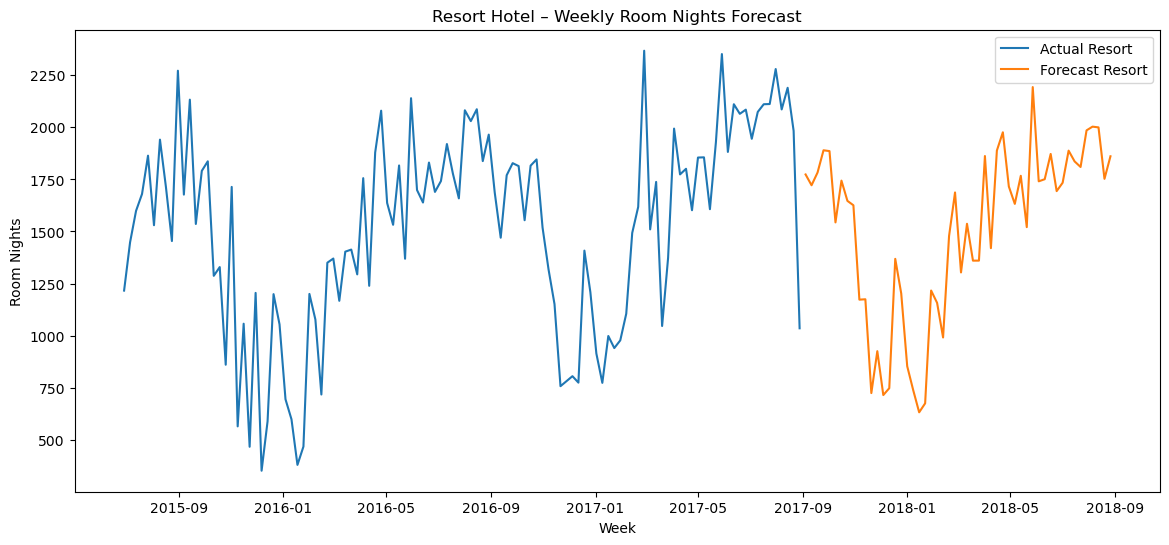

In [20]:
# Resort Hotel

plt.figure(figsize=(14, 6))
plt.plot(resort_series, label="Actual Resort")
plt.plot(resort_forecast, label="Forecast Resort")
plt.title("Resort Hotel – Weekly Room Nights Forecast")
plt.xlabel("Week")
plt.ylabel("Room Nights")
plt.legend()
plt.show()

In contrast, the Resort Hotel forecast closely aligns with recent historical demand levels and preserves clear seasonal dynamics. The forecasted pattern continues established peak and off-peak cycles with reasonable volatility, indicating that seasonality is a dominant and stable driver of Resort demand.

The absence of abrupt level shifts in the Resort forecast suggests that the seasonal ETS model is well matched to the underlying data-generating process. This reinforces the interpretation that Resort demand is structurally seasonal and less sensitive to short-term regime changes compared to City demand.

Consequently, the initial Resort forecast is suitable for downstream revenue, utilization, and financial planning analysis without further structural modification.

In [21]:
# Ensuring proper ordering and frequency
city_series = (
    weekly_pivot["City Hotel"]
    .sort_index()
    .asfreq("W-MON")
    .interpolate()
)

city_series.tail()

week_start
2017-07-31    2628
2017-08-07    2539
2017-08-14    2720
2017-08-21    1989
2017-08-28    1253
Freq: W-MON, Name: City Hotel, dtype: int64

In [22]:
ets_city = ExponentialSmoothing(
    city_series,
    trend=None,
    seasonal=None
).fit(optimized=True)

In [23]:
# Generate City Forecast (12 Months / 52 Weeks)
forecast_horizon = 52

city_forecast = ets_city.forecast(forecast_horizon)

city_forecast.head()

2017-09-04    1659.41889
2017-09-11    1659.41889
2017-09-18    1659.41889
2017-09-25    1659.41889
2017-10-02    1659.41889
Freq: W-MON, dtype: float64

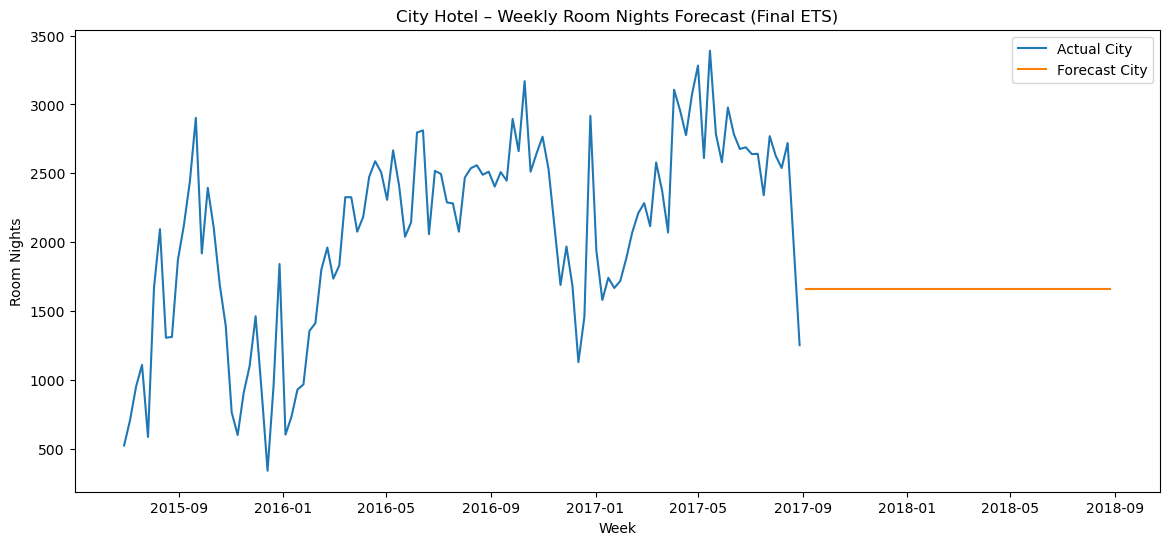

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(city_series, label="Actual City")
plt.plot(city_forecast, label="Forecast City")
plt.title("City Hotel – Weekly Room Nights Forecast (Final ETS)")
plt.xlabel("Week")
plt.ylabel("Room Nights")
plt.legend()
plt.show()


In [25]:
city_base   = city_forecast
city_up     = city_forecast * 1.10
city_down   = city_forecast * 0.90

City Hotel Forecast Interpretation

The City Hotel forecast is flat because historical demand exhibits multiple structural breaks and does not follow a stable long-term trend. In such cases, extrapolating growth or decline would introduce speculative bias. A local-level ETS model was therefore used to anchor forecasts to the most recent demand regime, with uncertainty addressed through scenario analysis rather than deterministic trend projection.